In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import random
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

# Loading the Dataset using PyTorch


In [2]:


data_dir = "/kaggle/input/human-face-emotions/Data"

transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor()
                               ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size= 32, shuffle= True)




In [3]:
print(dataset.classes)
print(dataset.class_to_idx)
print(f"Dataset Size = {len(dataset)}")


['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Sad': 3, 'Suprise': 4}
Dataset Size = 59099


## Lets look at a sample

In [4]:
image, label = dataset[31242]
print(f"Image shape = {image.shape}")
print(f"Image Label = {label}")
print(f"Label Name = {dataset.classes[label]}")

Image shape = torch.Size([3, 128, 128])
Image Label = 2
Label Name = Happy


## Visualize a few Examples

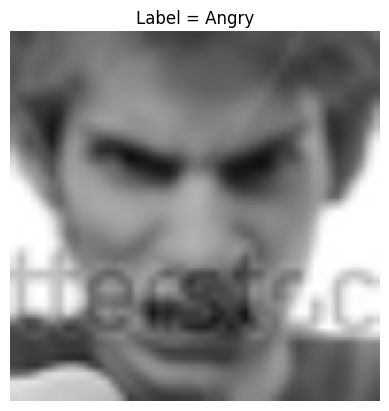

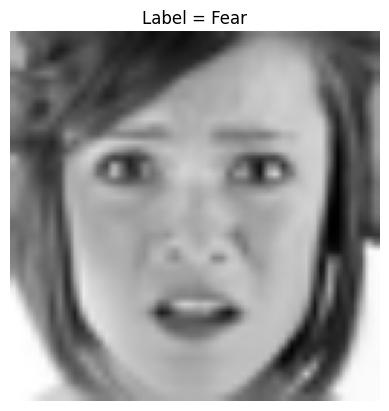

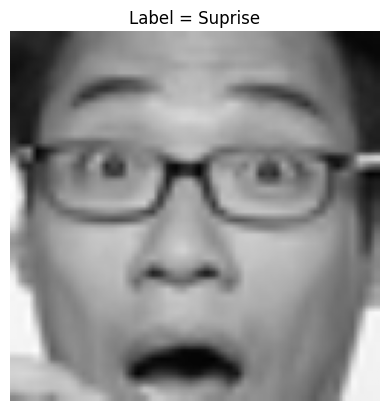

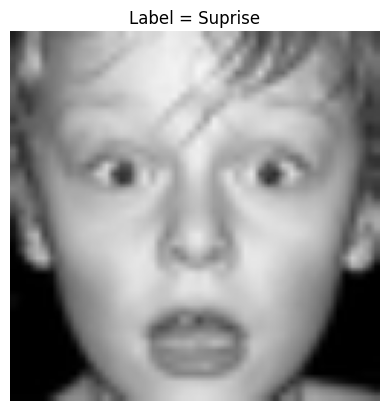

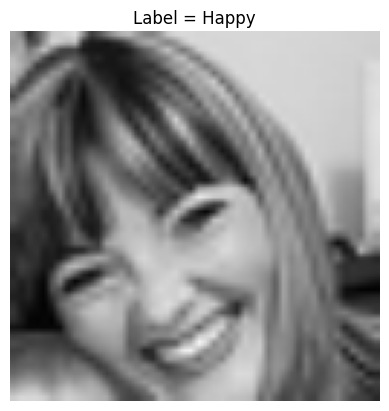

In [5]:
def show_image(img,label):
    img = img.permute(1,2,0).numpy()
    plt.imshow(img)
    plt.title(f"Label = {dataset.classes[label]}")
    plt.axis("off")
    plt.show()

for i in range(5):
    num = random.randint(1, len(dataset))
    image, label = dataset[i + num]
    show_image(image, label)


# Split the Dataset

In [6]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train size = {len(train_dataset)}")
print(f"Validation size = {len(val_dataset)}")
print(f"Test size = {len(test_dataset)}")

Train size = 41369
Validation size = 8864
Test size = 8866


## Create DataLoaders for all Sets

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Training Setup

In [8]:
class EmotionClassify_CNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionClassify_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3, padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 32 *32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Instantiate

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassify_CNN(num_classes= len(dataset.classes)).to(device)

### Setup the Loss and optimizer


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

## Actual Training 

In [11]:
from tqdm import tqdm
import time

num_epochs = 100

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    # Wrap the DataLoader with tqdm
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm with current loss
        loop.set_postfix(loss=running_loss / (loop.n + 1))

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_time:.1f}s, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/100: 100%|██████████| 647/647 [01:52<00:00,  5.73it/s, loss=1.44]


Epoch 1 completed in 112.8s, Loss: 1.4367


Epoch 2/100: 100%|██████████| 647/647 [01:13<00:00,  8.85it/s, loss=1.26]


Epoch 2 completed in 73.1s, Loss: 1.2587


Epoch 3/100: 100%|██████████| 647/647 [01:15<00:00,  8.55it/s, loss=1.12]


Epoch 3 completed in 75.7s, Loss: 1.1155


Epoch 4/100: 100%|██████████| 647/647 [01:13<00:00,  8.80it/s, loss=0.981]


Epoch 4 completed in 73.5s, Loss: 0.9761


Epoch 5/100: 100%|██████████| 647/647 [01:17<00:00,  8.39it/s, loss=0.854]


Epoch 5 completed in 77.1s, Loss: 0.8503


Epoch 6/100: 100%|██████████| 647/647 [01:13<00:00,  8.75it/s, loss=0.734]


Epoch 6 completed in 73.9s, Loss: 0.7342


Epoch 7/100: 100%|██████████| 647/647 [01:13<00:00,  8.75it/s, loss=0.629]


Epoch 7 completed in 73.9s, Loss: 0.6293


Epoch 8/100: 100%|██████████| 647/647 [01:14<00:00,  8.70it/s, loss=0.544]


Epoch 8 completed in 74.4s, Loss: 0.5432


Epoch 9/100: 100%|██████████| 647/647 [01:17<00:00,  8.37it/s, loss=0.47]


Epoch 9 completed in 77.3s, Loss: 0.4695


Epoch 10/100: 100%|██████████| 647/647 [01:13<00:00,  8.78it/s, loss=0.412]


Epoch 10 completed in 73.7s, Loss: 0.4106


Epoch 11/100: 100%|██████████| 647/647 [01:12<00:00,  8.93it/s, loss=0.373]


Epoch 11 completed in 72.4s, Loss: 0.3721


Epoch 12/100: 100%|██████████| 647/647 [01:13<00:00,  8.76it/s, loss=0.335]


Epoch 12 completed in 73.9s, Loss: 0.3349


Epoch 13/100: 100%|██████████| 647/647 [01:14<00:00,  8.74it/s, loss=0.313]


Epoch 13 completed in 74.1s, Loss: 0.3128


Epoch 14/100: 100%|██████████| 647/647 [01:16<00:00,  8.44it/s, loss=0.296]


Epoch 14 completed in 76.6s, Loss: 0.2952


Epoch 15/100: 100%|██████████| 647/647 [01:14<00:00,  8.74it/s, loss=0.282]


Epoch 15 completed in 74.0s, Loss: 0.2815


Epoch 16/100: 100%|██████████| 647/647 [01:17<00:00,  8.31it/s, loss=0.259]


Epoch 16 completed in 77.9s, Loss: 0.2594


Epoch 17/100: 100%|██████████| 647/647 [01:11<00:00,  9.01it/s, loss=0.256]


Epoch 17 completed in 71.8s, Loss: 0.2559


Epoch 18/100: 100%|██████████| 647/647 [01:13<00:00,  8.81it/s, loss=0.243]


Epoch 18 completed in 73.4s, Loss: 0.2426


Epoch 19/100: 100%|██████████| 647/647 [01:12<00:00,  8.87it/s, loss=0.226]


Epoch 19 completed in 72.9s, Loss: 0.2255


Epoch 20/100: 100%|██████████| 647/647 [01:11<00:00,  9.04it/s, loss=0.219]


Epoch 20 completed in 71.5s, Loss: 0.2188


Epoch 21/100: 100%|██████████| 647/647 [01:13<00:00,  8.77it/s, loss=0.218]


Epoch 21 completed in 73.8s, Loss: 0.2177


Epoch 22/100: 100%|██████████| 647/647 [01:11<00:00,  9.06it/s, loss=0.205]


Epoch 22 completed in 71.4s, Loss: 0.2045


Epoch 23/100: 100%|██████████| 647/647 [01:12<00:00,  8.96it/s, loss=0.207]


Epoch 23 completed in 72.2s, Loss: 0.2063


Epoch 24/100: 100%|██████████| 647/647 [01:16<00:00,  8.41it/s, loss=0.197]


Epoch 24 completed in 76.9s, Loss: 0.1967


Epoch 25/100: 100%|██████████| 647/647 [01:16<00:00,  8.42it/s, loss=0.195]


Epoch 25 completed in 76.8s, Loss: 0.1954


Epoch 26/100: 100%|██████████| 647/647 [01:22<00:00,  7.87it/s, loss=0.19]


Epoch 26 completed in 82.2s, Loss: 0.1898


Epoch 27/100: 100%|██████████| 647/647 [01:16<00:00,  8.44it/s, loss=0.184]


Epoch 27 completed in 76.7s, Loss: 0.1833


Epoch 28/100: 100%|██████████| 647/647 [01:15<00:00,  8.59it/s, loss=0.184]


Epoch 28 completed in 75.3s, Loss: 0.1840


Epoch 29/100: 100%|██████████| 647/647 [01:17<00:00,  8.38it/s, loss=0.179]


Epoch 29 completed in 77.2s, Loss: 0.1786


Epoch 30/100: 100%|██████████| 647/647 [01:14<00:00,  8.73it/s, loss=0.174]


Epoch 30 completed in 74.1s, Loss: 0.1737


Epoch 31/100: 100%|██████████| 647/647 [01:15<00:00,  8.59it/s, loss=0.173]


Epoch 31 completed in 75.3s, Loss: 0.1723


Epoch 32/100: 100%|██████████| 647/647 [01:15<00:00,  8.54it/s, loss=0.169]


Epoch 32 completed in 75.8s, Loss: 0.1685


Epoch 33/100: 100%|██████████| 647/647 [01:14<00:00,  8.73it/s, loss=0.168]


Epoch 33 completed in 74.1s, Loss: 0.1674


Epoch 34/100: 100%|██████████| 647/647 [01:14<00:00,  8.70it/s, loss=0.161]


Epoch 34 completed in 74.4s, Loss: 0.1608


Epoch 35/100: 100%|██████████| 647/647 [01:14<00:00,  8.73it/s, loss=0.161]


Epoch 35 completed in 74.1s, Loss: 0.1609


Epoch 36/100: 100%|██████████| 647/647 [01:18<00:00,  8.23it/s, loss=0.151]


Epoch 36 completed in 78.6s, Loss: 0.1510


Epoch 37/100: 100%|██████████| 647/647 [01:16<00:00,  8.49it/s, loss=0.152]


Epoch 37 completed in 76.2s, Loss: 0.1518


Epoch 38/100: 100%|██████████| 647/647 [01:15<00:00,  8.54it/s, loss=0.157]


Epoch 38 completed in 75.8s, Loss: 0.1567


Epoch 39/100: 100%|██████████| 647/647 [01:16<00:00,  8.46it/s, loss=0.155]


Epoch 39 completed in 76.5s, Loss: 0.1545


Epoch 40/100: 100%|██████████| 647/647 [01:13<00:00,  8.77it/s, loss=0.142]


Epoch 40 completed in 73.8s, Loss: 0.1424


Epoch 41/100: 100%|██████████| 647/647 [01:16<00:00,  8.46it/s, loss=0.148]


Epoch 41 completed in 76.5s, Loss: 0.1483


Epoch 42/100: 100%|██████████| 647/647 [01:15<00:00,  8.60it/s, loss=0.144]


Epoch 42 completed in 75.2s, Loss: 0.1430


Epoch 43/100: 100%|██████████| 647/647 [01:15<00:00,  8.54it/s, loss=0.138]


Epoch 43 completed in 75.8s, Loss: 0.1371


Epoch 44/100: 100%|██████████| 647/647 [01:14<00:00,  8.67it/s, loss=0.141]


Epoch 44 completed in 74.6s, Loss: 0.1408


Epoch 45/100: 100%|██████████| 647/647 [01:13<00:00,  8.80it/s, loss=0.137]


Epoch 45 completed in 73.5s, Loss: 0.1364


Epoch 46/100: 100%|██████████| 647/647 [01:12<00:00,  8.96it/s, loss=0.138]


Epoch 46 completed in 72.2s, Loss: 0.1378


Epoch 47/100: 100%|██████████| 647/647 [01:15<00:00,  8.54it/s, loss=0.138]


Epoch 47 completed in 75.7s, Loss: 0.1377


Epoch 48/100: 100%|██████████| 647/647 [01:13<00:00,  8.85it/s, loss=0.138]


Epoch 48 completed in 73.1s, Loss: 0.1376


Epoch 49/100: 100%|██████████| 647/647 [01:12<00:00,  8.96it/s, loss=0.137]


Epoch 49 completed in 72.2s, Loss: 0.1366


Epoch 50/100: 100%|██████████| 647/647 [01:15<00:00,  8.60it/s, loss=0.131]


Epoch 50 completed in 75.2s, Loss: 0.1307


Epoch 51/100: 100%|██████████| 647/647 [01:13<00:00,  8.82it/s, loss=0.13]


Epoch 51 completed in 73.3s, Loss: 0.1298


Epoch 52/100: 100%|██████████| 647/647 [01:14<00:00,  8.72it/s, loss=0.127]


Epoch 52 completed in 74.2s, Loss: 0.1262


Epoch 53/100: 100%|██████████| 647/647 [01:16<00:00,  8.44it/s, loss=0.128]


Epoch 53 completed in 76.7s, Loss: 0.1281


Epoch 54/100: 100%|██████████| 647/647 [01:15<00:00,  8.55it/s, loss=0.125]


Epoch 54 completed in 75.7s, Loss: 0.1250


Epoch 55/100: 100%|██████████| 647/647 [01:16<00:00,  8.47it/s, loss=0.122]


Epoch 55 completed in 76.4s, Loss: 0.1223


Epoch 56/100: 100%|██████████| 647/647 [01:14<00:00,  8.67it/s, loss=0.122]


Epoch 56 completed in 74.6s, Loss: 0.1216


Epoch 57/100: 100%|██████████| 647/647 [01:14<00:00,  8.74it/s, loss=0.126]


Epoch 57 completed in 74.1s, Loss: 0.1255


Epoch 58/100: 100%|██████████| 647/647 [01:15<00:00,  8.55it/s, loss=0.121]


Epoch 58 completed in 75.7s, Loss: 0.1203


Epoch 59/100: 100%|██████████| 647/647 [01:14<00:00,  8.66it/s, loss=0.117]


Epoch 59 completed in 74.7s, Loss: 0.1171


Epoch 60/100: 100%|██████████| 647/647 [01:11<00:00,  8.99it/s, loss=0.117]


Epoch 60 completed in 72.0s, Loss: 0.1167


Epoch 61/100: 100%|██████████| 647/647 [01:16<00:00,  8.43it/s, loss=0.117]


Epoch 61 completed in 76.8s, Loss: 0.1164


Epoch 62/100: 100%|██████████| 647/647 [01:11<00:00,  9.01it/s, loss=0.117]


Epoch 62 completed in 71.8s, Loss: 0.1167


Epoch 63/100: 100%|██████████| 647/647 [01:13<00:00,  8.75it/s, loss=0.115]


Epoch 63 completed in 74.0s, Loss: 0.1146


Epoch 64/100: 100%|██████████| 647/647 [01:12<00:00,  8.94it/s, loss=0.117]


Epoch 64 completed in 72.4s, Loss: 0.1164


Epoch 65/100: 100%|██████████| 647/647 [01:15<00:00,  8.55it/s, loss=0.112]


Epoch 65 completed in 75.6s, Loss: 0.1122


Epoch 66/100: 100%|██████████| 647/647 [01:15<00:00,  8.59it/s, loss=0.113]


Epoch 66 completed in 75.4s, Loss: 0.1123


Epoch 67/100: 100%|██████████| 647/647 [01:15<00:00,  8.57it/s, loss=0.111]


Epoch 67 completed in 75.5s, Loss: 0.1109


Epoch 68/100: 100%|██████████| 647/647 [01:16<00:00,  8.42it/s, loss=0.108]


Epoch 68 completed in 76.8s, Loss: 0.1078


Epoch 69/100: 100%|██████████| 647/647 [01:14<00:00,  8.72it/s, loss=0.112]


Epoch 69 completed in 74.2s, Loss: 0.1111


Epoch 70/100: 100%|██████████| 647/647 [01:15<00:00,  8.53it/s, loss=0.105]


Epoch 70 completed in 75.9s, Loss: 0.1044


Epoch 71/100: 100%|██████████| 647/647 [01:14<00:00,  8.69it/s, loss=0.107]


Epoch 71 completed in 74.4s, Loss: 0.1067


Epoch 72/100: 100%|██████████| 647/647 [01:15<00:00,  8.61it/s, loss=0.108]


Epoch 72 completed in 75.2s, Loss: 0.1079


Epoch 73/100: 100%|██████████| 647/647 [01:12<00:00,  8.92it/s, loss=0.109]


Epoch 73 completed in 72.6s, Loss: 0.1091


Epoch 74/100: 100%|██████████| 647/647 [01:15<00:00,  8.52it/s, loss=0.106]


Epoch 74 completed in 75.9s, Loss: 0.1055


Epoch 75/100: 100%|██████████| 647/647 [01:13<00:00,  8.83it/s, loss=0.101]


Epoch 75 completed in 73.3s, Loss: 0.1011


Epoch 76/100: 100%|██████████| 647/647 [01:15<00:00,  8.54it/s, loss=0.0998]


Epoch 76 completed in 75.8s, Loss: 0.0996


Epoch 77/100: 100%|██████████| 647/647 [01:17<00:00,  8.38it/s, loss=0.0993]


Epoch 77 completed in 77.2s, Loss: 0.0991


Epoch 78/100: 100%|██████████| 647/647 [01:16<00:00,  8.42it/s, loss=0.0981]


Epoch 78 completed in 76.8s, Loss: 0.0981


Epoch 79/100: 100%|██████████| 647/647 [01:13<00:00,  8.80it/s, loss=0.102]


Epoch 79 completed in 73.5s, Loss: 0.1012


Epoch 80/100: 100%|██████████| 647/647 [01:15<00:00,  8.62it/s, loss=0.104]


Epoch 80 completed in 75.0s, Loss: 0.1036


Epoch 81/100: 100%|██████████| 647/647 [01:14<00:00,  8.64it/s, loss=0.1]


Epoch 81 completed in 74.9s, Loss: 0.1004


Epoch 82/100: 100%|██████████| 647/647 [01:14<00:00,  8.71it/s, loss=0.0963]


Epoch 82 completed in 74.3s, Loss: 0.0962


Epoch 83/100: 100%|██████████| 647/647 [01:14<00:00,  8.64it/s, loss=0.0956]


Epoch 83 completed in 74.9s, Loss: 0.0953


Epoch 84/100: 100%|██████████| 647/647 [01:16<00:00,  8.48it/s, loss=0.0973]


Epoch 84 completed in 76.3s, Loss: 0.0973


Epoch 85/100: 100%|██████████| 647/647 [01:13<00:00,  8.75it/s, loss=0.0966]


Epoch 85 completed in 74.0s, Loss: 0.0965


Epoch 86/100: 100%|██████████| 647/647 [01:18<00:00,  8.28it/s, loss=0.0932]


Epoch 86 completed in 78.1s, Loss: 0.0932


Epoch 87/100: 100%|██████████| 647/647 [01:16<00:00,  8.48it/s, loss=0.0967]


Epoch 87 completed in 76.3s, Loss: 0.0962


Epoch 88/100: 100%|██████████| 647/647 [01:14<00:00,  8.68it/s, loss=0.0903]


Epoch 88 completed in 74.5s, Loss: 0.0902


Epoch 89/100: 100%|██████████| 647/647 [01:18<00:00,  8.23it/s, loss=0.0937]


Epoch 89 completed in 78.6s, Loss: 0.0933


Epoch 90/100: 100%|██████████| 647/647 [01:17<00:00,  8.35it/s, loss=0.0894]


Epoch 90 completed in 77.5s, Loss: 0.0894


Epoch 91/100: 100%|██████████| 647/647 [01:18<00:00,  8.27it/s, loss=0.0917]


Epoch 91 completed in 78.2s, Loss: 0.0917


Epoch 92/100: 100%|██████████| 647/647 [01:19<00:00,  8.18it/s, loss=0.088]


Epoch 92 completed in 79.1s, Loss: 0.0880


Epoch 93/100: 100%|██████████| 647/647 [01:13<00:00,  8.81it/s, loss=0.0861]


Epoch 93 completed in 73.4s, Loss: 0.0860


Epoch 94/100: 100%|██████████| 647/647 [01:16<00:00,  8.41it/s, loss=0.0863]


Epoch 94 completed in 76.9s, Loss: 0.0863


Epoch 95/100: 100%|██████████| 647/647 [01:15<00:00,  8.62it/s, loss=0.0905]


Epoch 95 completed in 75.0s, Loss: 0.0905


Epoch 96/100: 100%|██████████| 647/647 [01:14<00:00,  8.71it/s, loss=0.0859]


Epoch 96 completed in 74.3s, Loss: 0.0856


Epoch 97/100: 100%|██████████| 647/647 [01:13<00:00,  8.79it/s, loss=0.0861]


Epoch 97 completed in 73.6s, Loss: 0.0858


Epoch 98/100: 100%|██████████| 647/647 [01:15<00:00,  8.62it/s, loss=0.0878]


Epoch 98 completed in 75.1s, Loss: 0.0878


Epoch 99/100: 100%|██████████| 647/647 [01:14<00:00,  8.70it/s, loss=0.0856]


Epoch 99 completed in 74.3s, Loss: 0.0856


Epoch 100/100: 100%|██████████| 647/647 [01:14<00:00,  8.65it/s, loss=0.081]

Epoch 100 completed in 74.8s, Loss: 0.0806


In [12]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # make sure this matches below
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy = {100 * correct / total:.2f}%")

Validation Accuracy = 83.94%


# Lets test it now!


Test Accuracy = 84.24%


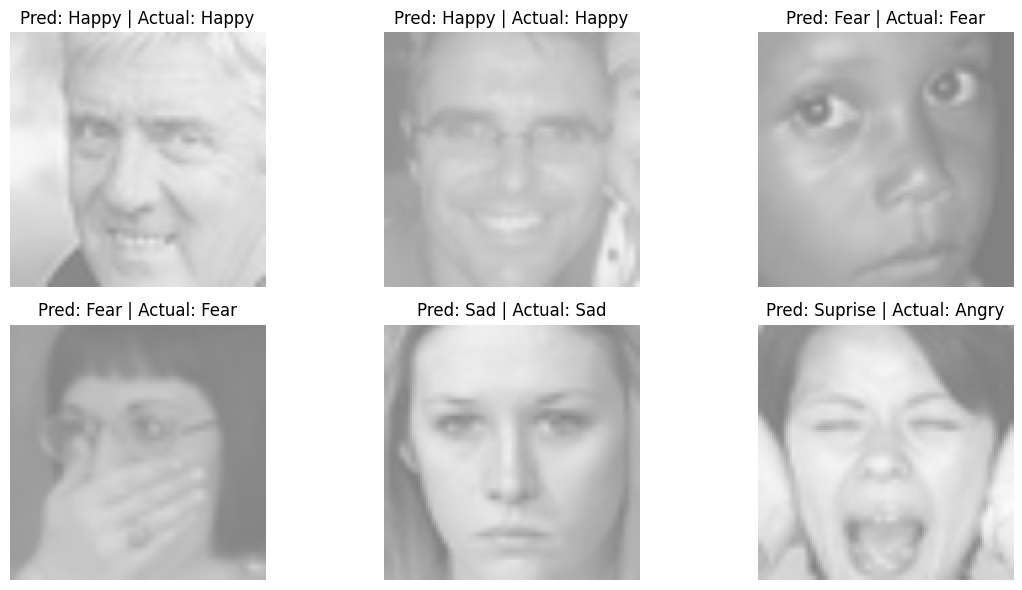

In [13]:
model.eval()
correct, total = 0, 0
# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in test_loader:  # <-- using test_loader here
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy = {100 * correct / total:.2f}%")

# Get class names from dataset
class_names = dataset.classes

# --- Display some sample results ---
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
# Get model predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)
# Move to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()
# Helper function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if you normalized to [-1,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
# Show a few images with predictions
num_images = 6
plt.figure(figsize=(12, 6))
for i in range(num_images):
    plt.subplot(2, 3, i + 1)
    imshow(images[i])
    # CHANGE: Use class_names to convert index to label name
    pred_label = class_names[predicted[i].item()]
    actual_label = class_names[labels[i].item()]
    plt.title(f"Pred: {pred_label} | Actual: {actual_label}")
plt.tight_layout()
plt.show()

# Saving the model weights for later use


In [14]:
torch.save(model.state_dict(), "emotion_cnn.pth")

In [15]:
model = EmotionClassify_CNN(num_classes = len(dataset.classes)).to(device)

model.load_state_dict(torch.load("emotion_cnn.pth", map_location=device))
model.eval()

EmotionClassify_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)